In [1]:
import math
import tensorflow as tf
import numpy as np
import EH_P2P
import PPO_CLASS

np.random.seed(1)
tf.random.set_seed(1)

#####################  Hyperparameters  ####################
MAX_TEST_EPISODES = 100
MAX_EP_STEPS = 120

state_dim = 3  # channel, battery, solar
action_dim = 1  # Transmission power
action_bound = 1  # [0,1]
Modulation_type = 0  # e.g., 0 for QPSK, 1 for 8PSK
epsilon = 0.2  # Not used in testing but needed for model initialization

env = EH_P2P.EH_P2P()
env.Chanpower()
env.Solartest()

# Load PPO model
actor = PPO_CLASS.PPOActorCritic(state_dim, action_dim, action_bound, lr_actor=0.0002, lr_critic=0.0002, gamma=0.999, epsilon=epsilon)

def load_weights(actor, snr, episode):
    """Load the saved weights for the actor model."""
    actor.actor_model.load_weights(f"checkpoints/actor_weights_SNR={snr}_Episode={episode}.weights.h5")
    print(f"Weights loaded for SNR={snr}, Episode={episode}.")

# Testing loop
for snr in range(0, 2, 2):
    print(f"Testing started for SNR: {snr}")

    # Load the weights for the given SNR
    load_weights(actor, snr, episode=499)

    total_rewards = []
    total_net_bit_rates = []

    for episode in range(MAX_TEST_EPISODES):
        s = env.reset_P2P(snr)
        s = (s - np.mean(s)) / (np.std(s) + 1e-8)  # Normalize the initial state
        ep_reward = 0
        net_bit_rates = []

        for step in range(MAX_EP_STEPS):
            s_array = np.array(s, dtype=np.float32).reshape(1, state_dim)

            # Get action from the trained actor
            a, _ = actor.get_action_and_log_prob(s_array)
            a = np.clip(a, 0, 1) * action_bound

            # Step the environment
            s_, r, info = env.step_P2P([a[0], Modulation_type])
            s_ = (s_ - np.mean(s_)) / (np.std(s_) + 1e-8)  # Normalize the new state
            net_bit_rates.append(info.get("net_bit_rate", 0))  # Assuming info contains net bit rate

            s = s_
            ep_reward += r

        # Store rewards and bit rates
        total_rewards.append(ep_reward)
        total_net_bit_rates.append(np.mean(net_bit_rates))

        print(f"Episode: {episode}, Total Reward: {ep_reward:.2f}, Average Net Bit Rate: {np.mean(net_bit_rates):.2f}")

    print(f"Testing complete for SNR={snr}. Average Reward: {np.mean(total_rewards):.2f}, Average Net Bit Rate: {np.mean(total_net_bit_rates):.2f}")

print("----------------------------END--------------------------------")


Testing started for SNR: 0
Weights loaded for SNR=0, Episode=499.
Episode: 0, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 1, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 2, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 3, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 4, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 5, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 6, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 7, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 8, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 9, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 10, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 11, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 12, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episode: 13, Total Reward: 12773460.66, Average Net Bit Rate: 0.00
Episod

In [1]:
import math
import tensorflow as tf
import numpy as np
import EH_P2P
import PPO_CLASS

np.random.seed(1)
tf.random.set_seed(1)

#####################  Hyperparameters  ####################
MAX_TEST_EPISODES = 1
MAX_EP_STEPS = 100000  # Matching DDPG_Test step count
state_dim = 3  # Channel, battery, solar
action_dim = 1  # Transmission power
action_bound = 1  # [0,1]
Modulation_type = 0  # e.g., 0 for QPSK, 1 for 8PSK
epsilon = 0.2  # Not used in testing but needed for model initialization

env = EH_P2P.EH_P2P()
env.Chanpower()
env.Solartest()

B = np.zeros((100, 4))  # Store average rewards

def choose_action(s, actor):
    """
    Get action from actor model for the given state `s`.
    """
    s_array = np.array(s, dtype=np.float32).reshape(1, state_dim)
    a, _ = actor.get_action_and_log_prob(s_array)
    a = np.clip(a, 0, 1) * action_bound  # Ensure action is within bounds
    return a

def load_weights(actor, snr, episode):
    """Load the saved weights for the actor model."""
    actor.actor_model.load_weights(f"checkpoints/actor_weights_SNR={snr}_Episode={episode}.weights.h5")
    print(f"Weights loaded for SNR={snr}, Episode={episode}.")

snrList = []
ave_reward = []

# Testing loop
for snr in range(0, 2, 2):  # SNR range similar to DDPG_Test
    epoch = 499  # Assuming epoch 499 for testing
    snrList.append(snr)

    # Reset TensorFlow session
    tf.keras.backend.clear_session()
    print(f"Testing started for SNR: {snr}")

    # Load PPO model
    actor = PPO_CLASS.PPOActorCritic(state_dim, action_dim, action_bound, lr_actor=0.0002, lr_critic=0.0002, gamma=0.999, epsilon=epsilon)
    load_weights(actor, snr, epoch)

    for i in range(MAX_TEST_EPISODES):
        s = env.reset_P2P(snr=snr)
        s = np.reshape(s, (1, -1))
        ep_reward = 0

        for j in range(MAX_EP_STEPS):
            # Select action
            a = choose_action(s, actor)

            # Step environment
            s_, r, info = env.step_P2P([a[0], Modulation_type])

            # Update state and reward
            s = s_
            ep_reward += r

            # Log progress every 10000 steps
            if (j + 1) % 10000 == 0:
                print(f"Net bit rate: {ep_reward / (j + 1):.2f}, SNR: {snr}, Modulation: {Modulation_type}, Loop: {i}, Action: {a.flatten()}, Noise: {env.noise}")
                ave_reward.append(B[int(index), int(Modulation_type)]) 

        # Compute average reward for SNR and Modulation
        index = (snr + 10) // 2
        B[int(index), int(Modulation_type)] = ep_reward / MAX_EP_STEPS
        print(f"Average Reward for SNR={snr}, Modulation={Modulation_type}: {B[int(index), int(Modulation_type)]:.2f}")

    print(f"Testing complete for SNR={snr}. Average Reward: {np.mean(ave_reward):.2f}")

print("----------------------------END--------------------------------")


Testing started for SNR: 0
Weights loaded for SNR=0, Episode=499.
Net bit rate: 142046.88, SNR: 0, Modulation: 0, Loop: 0, Action: [0.976306], Noise: 1.0
Net bit rate: 143172.69, SNR: 0, Modulation: 0, Loop: 0, Action: [0.9483922], Noise: 1.0
Net bit rate: 143288.39, SNR: 0, Modulation: 0, Loop: 0, Action: [0.769727], Noise: 1.0
Net bit rate: 144182.06, SNR: 0, Modulation: 0, Loop: 0, Action: [0.9740862], Noise: 1.0
Net bit rate: 143969.06, SNR: 0, Modulation: 0, Loop: 0, Action: [0.9322732], Noise: 1.0
Net bit rate: 143599.17, SNR: 0, Modulation: 0, Loop: 0, Action: [0.9144622], Noise: 1.0
Net bit rate: 143562.62, SNR: 0, Modulation: 0, Loop: 0, Action: [0.90346116], Noise: 1.0
Net bit rate: 144097.43, SNR: 0, Modulation: 0, Loop: 0, Action: [0.91661215], Noise: 1.0
Net bit rate: 143535.73, SNR: 0, Modulation: 0, Loop: 0, Action: [0.64037377], Noise: 1.0
Net bit rate: 143335.00, SNR: 0, Modulation: 0, Loop: 0, Action: [0.3594579], Noise: 1.0
Average Reward for SNR=0, Modulation=0: 143

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'checkpoints/actor_weights_SNR=2_Episode=499.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
ave_reward

[143335.00057559513]

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

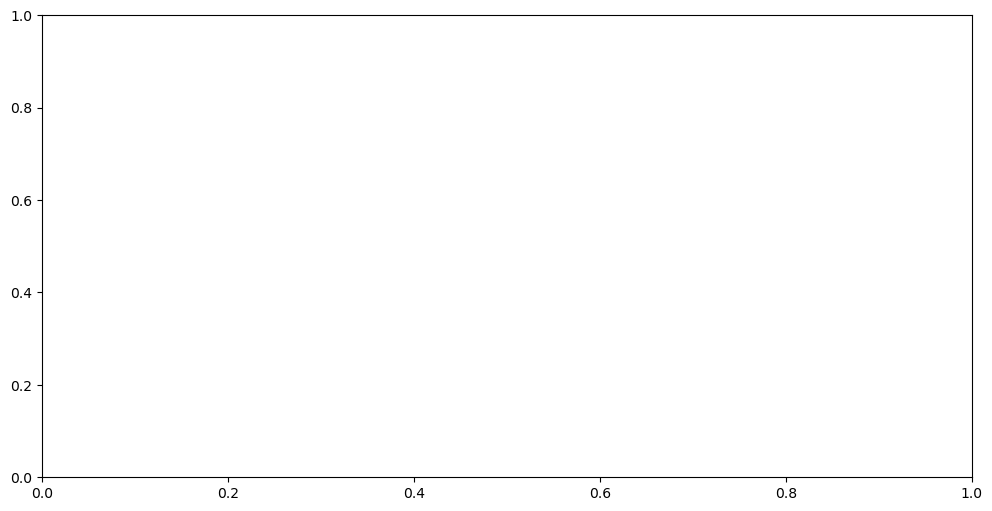

In [2]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(snrList, ave_reward, marker='+', linestyle='-', linewidth=2)

# Add labels and title
plt.title('PPO Algorithm Average net bit rate vs SNR', fontsize=14)
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Average net bit rate (bit/sec)', fontsize=12)

# Add grid for better visualization
plt.grid(True)

# Save the plot
plt.savefig('PPO Algorithm average_reward_vs_snr(dB).png', dpi=400, bbox_inches='tight')

# Show the plot
plt.show()